#Taxonomy abundance plot

First, we install phyloseq and necessary libraries. This process may take a while.

In [ ]:
#Install phyloseq and necessary libraries
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

  BiocManager::install("phyloseq")

  install.packages(c("RColorBrewer", "patchwork", "pals"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'BiocVersion', 'phyloseq'

also installing the dependencies ‘bitops’, ‘Rhdf5lib’, ‘rhdf5filters’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘pixmap’, ‘sp’, ‘Rcpp’, ‘RcppArmadillo’, ‘rhdf5’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘GenomeInfoDb’, ‘iterators’, ‘permute’, ‘ade4’, ‘ape’, ‘Biobase’, ‘BiocGenerics’, ‘biomformat’, ‘Biostrings’, ‘foreach’, ‘igraph’, ‘multtest’, ‘plyr’, ‘reshape2’, ‘vegan’


Old packages: 'bit', 'curl', 'dbplyr', 'devtools', 'evaluate', 'gargle',
  'highr', 'isoband', 'knitr', 'openssl', 'ragg', 'roxygen2', 'textshaping',
  'utf8', 'whisker', 'withr', 'xfun', 'boot'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dic

Next, we import the installed libraries

In [ ]:
library("phyloseq")
library("ggplot2")
library("RColorBrewer")
library("patchwork")
library("pals")
library("glue")
library(dplyr)

 We defined a function to identify and retrieve the most highly represented taxons within biological samples based on the specified taxonomic level.

 This function allows you to determine which organisms, whether at the species, family, class, or other taxonomic level, dominate the samples in terms of their abundance.

 It returns a subset of the original dataframe where only entries that correspond to the most represented taxa are kept. The rest of the information is summarized in a new row where the abundances of the rest of the sample is summed and labeled as "Other" (Making reference to the non most abundant taxa).

In [ ]:
get_most_abundant <- function(df, num, tax_rank)
{
    # An auxiliary df is created to perform grouping by taxonomic levels and calculate the total abundance of their taxa.
    # The df is then sorted based on the total abundance of the taxa.
    df_aux <- df[, c(tax_rank, "Abundance")]
    df_aux <- df_aux %>%
        group_by(!!sym(tax_rank)) %>%
            summarize(Total_Abundance = sum(Abundance)) %>% arrange(desc(Total_Abundance))

    # Select top most abundant
    most_abundant <- head(df_aux, n = num)

    # The orignal df is filtered by most abundant taxa selected before
    filtered_df <- df[df[[tax_rank]] %in% most_abundant[[tax_rank]], ]
    # The not most abundant taxa are stored in unfilterd_df
    unfiltered_df <- df[!(df[[tax_rank]] %in% most_abundant[[tax_rank]]), ]

    # The unfiltered df is groupped by sample name in the unfiltered_df and sum abundances
    df_aux3 <- unfiltered_df[, c("Sample", "Abundance")]
    df_aux4 <- df_aux3 %>%
        group_by(Sample) %>%
        summarize(Total_Abundance = sum(Abundance)) %>% arrange(desc(Total_Abundance))

    # We add a new entry to the filtered_df for each sample with its abundance sum
    for (sample in df_aux4$Sample)
    {
        new_row <- data.frame(OTU = 0, Sample = sample, Abundance = df_aux4$Total_Abundance[df_aux4$Sample == sample], Id = sample)
        num_cols <- ncol(filtered_df)

        if (num_cols > 4)
        {
            new_row <- cbind(new_row, matrix('Other', nrow = 1, ncol = num_cols - 4))
        }

        colnames(new_row) <- colnames(filtered_df)
        filtered_final <- rbind(filtered_df, new_row)
    }

    # The filtered df with the new entries is returned
    return (filtered_final)

}



After that we established the main function for the plot generation

In [ ]:
plot_taxonomy <- function(merged_metagenomes, tax_level, n_top, n_colors, relative = FALSE)
{
    # The phyloseq object is trimmed to remove data prefixes
    merged_metagenomes@tax_table@.Data <- substring(merged_metagenomes@tax_table@.Data, 4)

    # The names of the columns are adjusted
    colnames(merged_metagenomes@tax_table@.Data)<- c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")

    # Only the bacterial taxons are kept
    merged_metagenomes <- subset_taxa(merged_metagenomes, Kingdom == "Bacteria")

    # The entries where the specified taxonomic level was not identified are dropped
    merged_metagenomes <- subset_taxa(merged_metagenomes, sym(tax_level) != "")

    #If the relative abundance plot is required, we normalice the abundance.
    if (!relative)
    {
        glom <- tax_glom(physeq = merged_metagenomes, taxrank = tax_level)
        df <- psmelt(glom)
        if (tax_level == 'Species')
        {
            df$Species <- paste(df$Genus, df$Species, sep = " ") #The genus and species name is concatenated
        }
    }
    else
    {
        percentages <- transform_sample_counts(merged_metagenomes, function(x) x*100 / sum(x) )
        glom <- tax_glom(percentages, taxrank = tax_level)
        df <- psmelt(glom)
        if (tax_level == 'Species')
        {
            df$Species <- paste(df$Genus, df$Species, sep = " ") #The genus and species name is concatenated
        }
    }

    # The most abundant taxa is selected
    df <- get_most_abundant(df, n_top, tax_level)

    # The color palette is generated
    colors<- colorRampPalette(alphabet(n_colors)) (length(unique(df[[tax_level]])))

    # We generate the stacked bar plot
    plot <- ggplot(data= df, aes(x=Sample, y=Abundance, fill=!!sym(tax_level)))+geom_bar(aes(), stat="identity", position="stack")+scale_fill_manual(values = colors)

    return (plot)

}

This is an example of how the functions would be run, using a Bracken biom file

In [ ]:
merged_metagenomes <- import_biom("latinbiota_bracken.biom")
tax <- "Class"

abs <- plot_taxonomy(merged_metagenomes, tax_level = tax, n_top =  20, n_colors = 9)
rel <- plot_taxonomy(merged_metagenomes, tax_level = tax, n_top =  20, n_colors = 9, relative = TRUE)

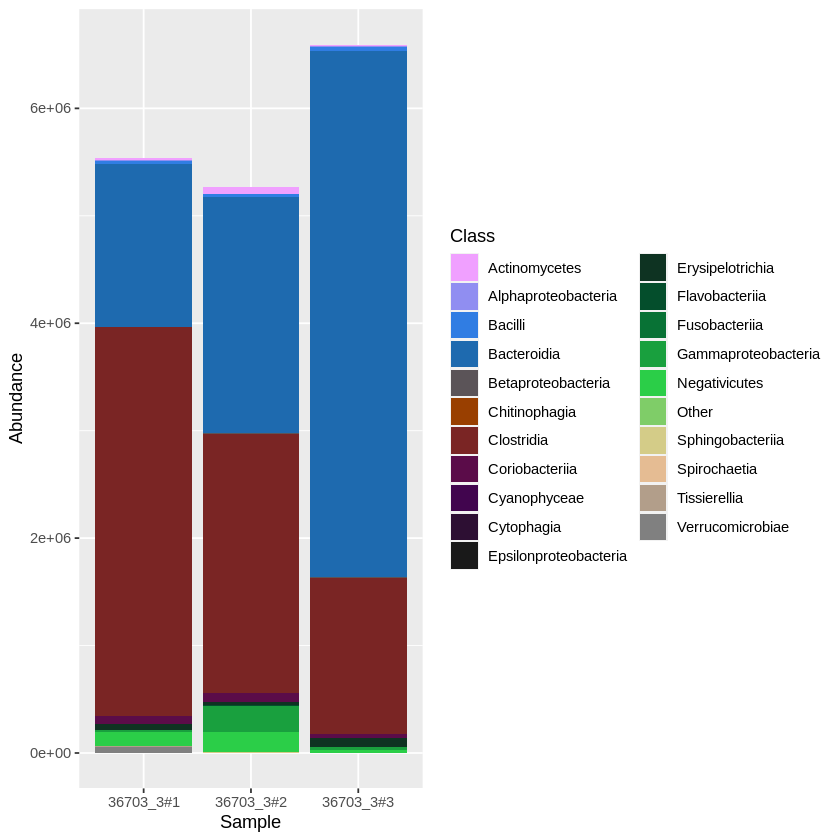

In [ ]:
abs

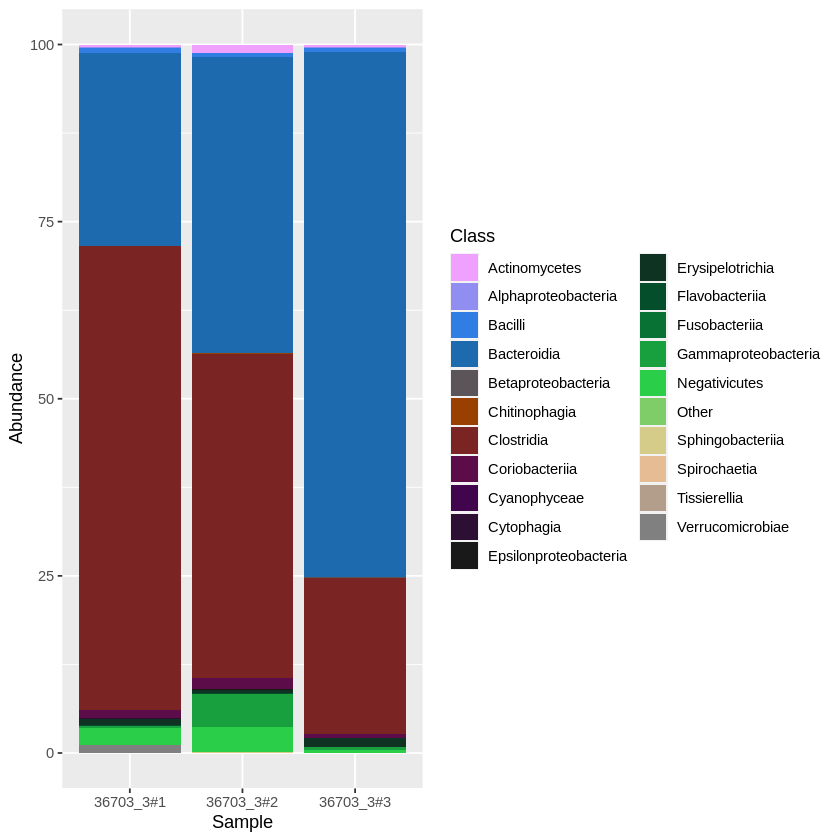

In [ ]:
rel

In [ ]:
ggsave(glue("{tax_level}AbsoluteAbundance.png"), plot = abs, width = 4500, height = 2950, units = "px", dpi = 400)

In [ ]:
ggsave(glue("{tax_level}RelativeAbundance.png"), plot = rel, width = 4500, height = 2950, units = "px", dpi = 400)